In [1]:
!rm -rf PsychRNN
!git clone https://github.com/murraylab/PsychRNN.git
%cd PsychRNN
!pip install -e .


Cloning into 'PsychRNN'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 628 (delta 88), reused 72 (delta 53), pack-reused 497 (from 1)
Receiving objects: 100% (628/628), 1.83 MiB | 6.66 MiB/s, done.
Resolving deltas: 100% (334/334), done.
/content/PsychRNN
Obtaining file:///content/PsychRNN
  Preparing metadata (setup.py) ... done
  Running setup.py develop for PsychRNN


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API



=== Stage 0: delay=[2,6], dist=0.0, lambda_rehe=0.0, its=400 ===
Iter 0 | Loss=0.692488 | Aux=1.377699 | Rehe=0.458248 | Acc=0.500
Iter 200 | Loss=0.008739 | Aux=0.000788 | Rehe=0.368723 | Acc=1.000

=== Stage 1: delay=[4,12], dist=0.05, lambda_rehe=0.0, its=600 ===
Iter 0 | Loss=0.004426 | Aux=0.000220 | Rehe=0.350165 | Acc=1.000
Iter 200 | Loss=0.000521 | Aux=0.000134 | Rehe=0.369372 | Acc=1.000
Iter 400 | Loss=0.000345 | Aux=0.000072 | Rehe=0.367645 | Acc=1.000

=== Stage 2: delay=[6,20], dist=0.1, lambda_rehe=1e-06, its=800 ===
Iter 0 | Loss=3.081165 | Aux=0.000056 | Rehe=0.371343 | Acc=0.359
Iter 200 | Loss=0.702777 | Aux=0.000122 | Rehe=0.004600 | Acc=0.641
Iter 400 | Loss=0.691633 | Aux=0.000060 | Rehe=0.002860 | Acc=0.531
Iter 600 | Loss=0.695395 | Aux=0.000039 | Rehe=0.001911 | Acc=0.547

=== Stage 3: delay=[10,30], dist=0.2, lambda_rehe=5e-05, its=1000 ===
Iter 0 | Loss=0.696476 | Aux=0.000027 | Rehe=0.001385 | Acc=0.594
Iter 200 | Loss=0.693807 | Aux=0.000019 | Rehe=0.00005

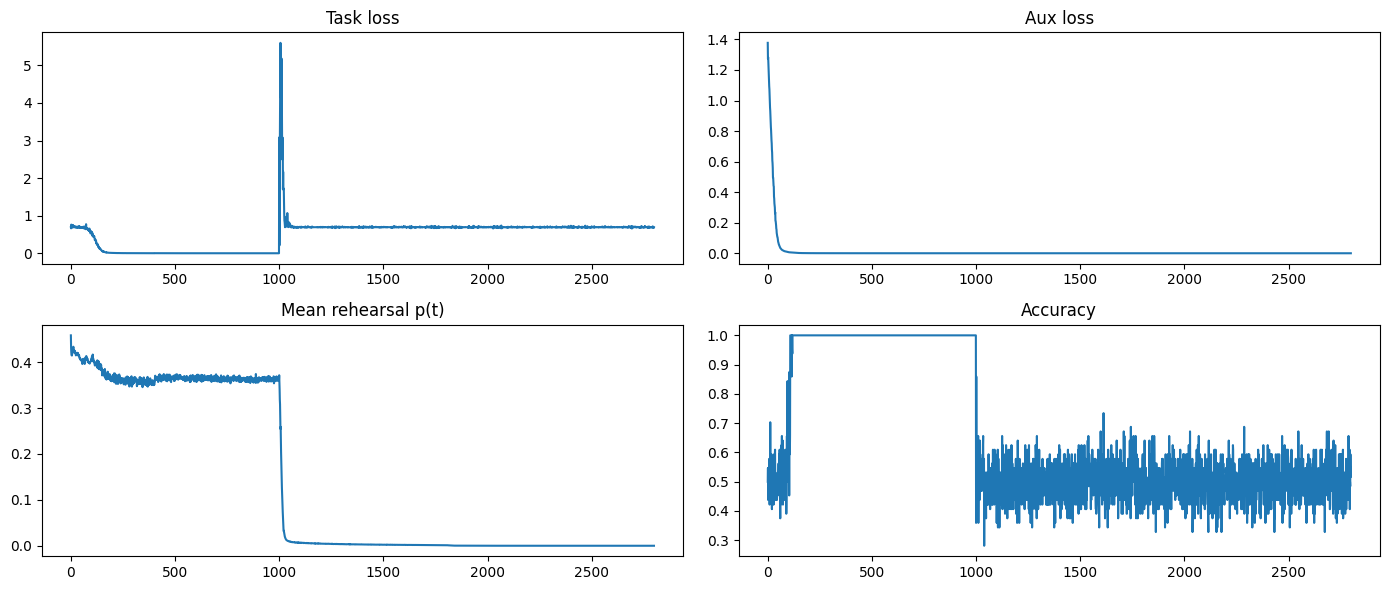

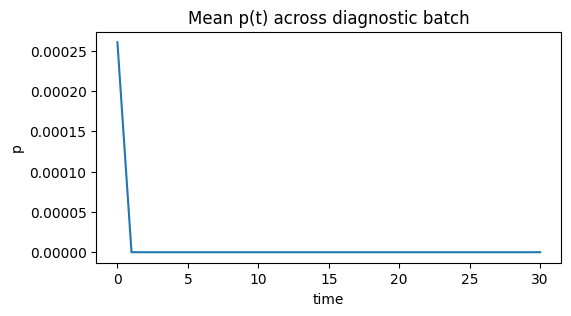

Memory decode acc (example batch): 1.0
Ablation accuracy (lambda_rehe=1.0): 0.50234375
Checkpoint saved to ./adr_full_corrected_ckpt


In [2]:
import time, math, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.compat.v1.set_random_seed(SEED)


INPUT_STIM = 4
INPUT_DIST = 4
SAMPLE_FLAG_IDX = INPUT_STIM + INPUT_DIST
INPUT_DIM = INPUT_STIM + INPUT_DIST + 1
N_STIM = INPUT_STIM
OUTPUT_DIM = 1
HIDDEN = 128
MEM_DIM = 32
MICRO_STEPS = 3

BATCH = 64
LR = 1e-3

CURRICULUM = [
    (2, 6,  0.0,  400, 0.0),
    (4, 12, 0.05, 600, 0.0),
    (6, 20, 0.10, 800, 1e-6),
    (10,30, 0.20,1000, 5e-5)
]

MEM_DECAY = 0.02
LAMBDA_AUX = 0.5

PRINT_EVERY = 200

def generate_dms_batch(batch_size, delay_range=(4,12), distractor_prob=0.0,
                       n_stim=N_STIM, n_distractors=INPUT_DIST, sample_flag_idx=SAMPLE_FLAG_IDX):
    N_in = n_stim + n_distractors + 1
    stim = np.random.randint(0, n_stim, size=batch_size)
    is_match = np.random.binomial(1, 0.5, size=batch_size)
    probe = np.where(is_match==1, stim, (stim + np.random.randint(1, n_stim, size=batch_size)) % n_stim)

    delays = np.random.randint(delay_range[0], delay_range[1]+1, size=batch_size)
    max_delay = np.max(delays)

    sample_time = 0
    probe_time = sample_time + max_delay
    T = probe_time + 1

    x = np.zeros((batch_size, T, N_in), dtype=np.float32)
    y = np.zeros((batch_size, T, OUTPUT_DIM), dtype=np.float32)
    mask = np.zeros((batch_size, T, OUTPUT_DIM), dtype=np.float32)

    for b in range(batch_size):
        x[b, sample_time, stim[b]] = 1.0
        x[b, sample_time, sample_flag_idx] = 1.0

    for b in range(batch_size):
        for t in range(sample_time+1, probe_time):
            if np.random.rand() < distractor_prob:
                ch = np.random.randint(n_stim, n_stim + n_distractors)
                x[b, t, ch] = 1.0

    for b in range(batch_size):
        x[b, probe_time, probe[b]] = 1.0

    for b in range(batch_size):
        y[b, probe_time, 0] = float(is_match[b])
        mask[b, probe_time, 0] = 1.0

    meta = {'stim': stim, 'probe': probe, 'delays': delays, 'probe_time': probe_time}
    return x, y, mask, meta


from tensorflow.python.ops import rnn_cell_impl

class ADRCell(rnn_cell_impl.RNNCell):
    def __init__(self, input_dim, hidden_dim, mem_dim, micro_steps=3, mem_decay=0.02):
        super(ADRCell, self).__init__(name="ADRCell")
        self._in = input_dim
        self._h = hidden_dim
        self._m = mem_dim
        self._k = micro_steps
        self._decay = tf.constant(mem_decay, dtype=tf.float32)

    @property
    def state_size(self):
        return self._h + self._m + self._m + 1

    @property
    def output_size(self):
        return self._h + 1

    def build(self, input_shape):
        in_dim = input_shape[-1]
        self.W_in = tf.compat.v1.get_variable("W_in", [in_dim, self._h], initializer=tf.compat.v1.keras.initializers.glorot_normal())
        self.U = tf.compat.v1.get_variable("U", [self._h, self._h], initializer=tf.compat.v1.keras.initializers.glorot_normal())
        self.b = tf.compat.v1.get_variable("b", [self._h], initializer=tf.zeros_initializer())

        self.cw1 = tf.compat.v1.get_variable("cw1", [self._h, 64], initializer=tf.compat.v1.keras.initializers.glorot_normal())
        self.cb1 = tf.compat.v1.get_variable("cb1", [64], initializer=tf.zeros_initializer())
        self.cw2 = tf.compat.v1.get_variable("cw2", [64,1], initializer=tf.compat.v1.keras.initializers.glorot_normal())
        self.cb2 = tf.compat.v1.get_variable("cb2", [1], initializer=tf.zeros_initializer())

        self.Wm = tf.compat.v1.get_variable("Wm", [self._h, self._m], initializer=tf.compat.v1.keras.initializers.glorot_normal())
        self.Wr = tf.compat.v1.get_variable("Wr", [self._m, in_dim], initializer=tf.compat.v1.keras.initializers.glorot_normal())

        super(ADRCell, self).build(input_shape)

    def _rnn_step(self, x, h):
        return tf.tanh(tf.matmul(x, self.W_in) + tf.matmul(h, self.U) + self.b)

    def call(self, inputs, state):
        h = state[:, :self._h]
        m = state[:, self._h:self._h+self._m]
        m_sample = state[:, self._h+self._m:self._h+2*self._m]
        saw = state[:, -1:]

        sample_present = tf.reduce_sum(inputs[:, :N_STIM], axis=1, keepdims=True) > 0.0
        new_sample = tf.logical_and(sample_present, tf.equal(saw, 0.0))

        h1 = self._rnn_step(inputs, h)

        m_cand = tf.matmul(h1, self.Wm)
        m_decayed = (1.0 - self._decay) * m
        m_new = tf.where(sample_present, m_cand, m_decayed)
        m_sample_new = tf.where(new_sample, m_cand, m_sample)
        saw_new = tf.where(new_sample, tf.ones_like(saw), saw)

        c1 = tf.nn.relu(tf.matmul(h1, self.cw1) + self.cb1)
        p = tf.sigmoid(tf.matmul(c1, self.cw2) + self.cb2)  # (B,1)

        replay_raw = tf.matmul(m_new, self.Wr)
        replay_scaled = replay_raw * tf.stop_gradient(p)

        def cond(i, h_acc):
            return tf.less(i, tf.constant(self._k))
        def body(i, h_acc):
            h2 = self._rnn_step(replay_scaled, h_acc)
            return [tf.add(i, 1), h2]
        _, h_final = tf.while_loop(cond, body, [tf.constant(0), h1], parallel_iterations=1)

        p_flat = tf.reshape(p, [-1, 1])
        output = tf.concat([h_final, p_flat], axis=1)
        new_state = tf.concat([h_final, m_new, m_sample_new, tf.cast(saw_new, tf.float32)], axis=1)
        return output, new_state

class ADRNet:
    def __init__(self, input_size=INPUT_DIM, hidden=HIDDEN, mem=MEM_DIM, k_micro=MICRO_STEPS, lr=LR):
        self.input_size = input_size; self.hidden = hidden; self.mem = mem; self.k = k_micro; self.lr = lr
        self._build_graph()

    def _build_graph(self):
        tf.compat.v1.reset_default_graph()
        self.x = tf.compat.v1.placeholder(tf.float32, [None, None, self.input_size], name='x')
        self.y = tf.compat.v1.placeholder(tf.float32, [None, None, OUTPUT_DIM], name='y')
        self.mask = tf.compat.v1.placeholder(tf.float32, [None, None, OUTPUT_DIM], name='mask')
        self.sample_labels = tf.compat.v1.placeholder(tf.int32, [None], name='sample_labels')

        batch_dyn = tf.shape(self.x)[1]
        cell = ADRCell(self.input_size, self.hidden, self.mem, self.k, mem_decay=MEM_DECAY)
        init_state = tf.zeros([batch_dyn, cell.state_size], dtype=tf.float32)

        outputs, final_state = tf.compat.v1.nn.dynamic_rnn(cell, self.x, initial_state=init_state, time_major=True, dtype=tf.float32)

        self.h_out = outputs[:, :, :self.hidden]
        self.p_out = outputs[:, :, self.hidden]

        with tf.compat.v1.variable_scope("readout"):
            W = tf.compat.v1.get_variable("W_out", [self.hidden, OUTPUT_DIM], initializer=tf.compat.v1.keras.initializers.glorot_normal())
            b = tf.compat.v1.get_variable("b_out", [OUTPUT_DIM], initializer=tf.zeros_initializer())
            T_dim = tf.shape(self.h_out)[0]
            hflat = tf.reshape(self.h_out, [-1, self.hidden])
            logits_flat = tf.matmul(hflat, W) + b
            self.logits = tf.reshape(logits_flat, [T_dim, batch_dyn, OUTPUT_DIM])
            self.probs = tf.sigmoid(self.logits)

        loss_mat = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.logits)
        self.task_loss = tf.reduce_sum(loss_mat * self.mask) / tf.cast(batch_dyn, tf.float32)

        m_sample = final_state[:, self.hidden + self.mem : self.hidden + 2*self.mem]  # B x mem

        with tf.compat.v1.variable_scope("mem_class"):
            W1 = tf.compat.v1.get_variable("W1", [self.mem, 64], initializer=tf.compat.v1.keras.initializers.glorot_normal())
            b1 = tf.compat.v1.get_variable("b1", [64], initializer=tf.zeros_initializer())
            W2 = tf.compat.v1.get_variable("W2", [64, N_STIM], initializer=tf.compat.v1.keras.initializers.glorot_normal())
            b2 = tf.compat.v1.get_variable("b2", [N_STIM], initializer=tf.zeros_initializer())
            mh = tf.nn.relu(tf.matmul(m_sample, W1) + b1)
            self.mem_logits = tf.matmul(mh, W2) + b2

        self.aux_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.sample_labels, logits=self.mem_logits))
        self.rehe_cost = tf.reduce_mean(self.p_out)

        self.lambda_rehe = tf.compat.v1.placeholder_with_default(0.0, shape=(), name='lambda_rehe')
        self.lambda_aux = tf.compat.v1.placeholder_with_default(0.0, shape=(), name='lambda_aux')

        self.total_loss = self.task_loss + self.lambda_rehe * self.rehe_cost + self.lambda_aux * self.aux_loss

        opt = tf.compat.v1.train.AdamOptimizer(self.lr)
        self.train_op = opt.minimize(self.total_loss)

        self.init = tf.compat.v1.global_variables_initializer()
        self.saver = tf.compat.v1.train.Saver(max_to_keep=3)

    def make_feed(self, x_np, y_np, mask_np, sample_labels_np, lambda_rehe=0.0, lambda_aux=0.0):
        return {self.x: x_np, self.y: y_np, self.mask: mask_np,
                self.sample_labels: sample_labels_np,
                self.lambda_rehe: lambda_rehe, self.lambda_aux: lambda_aux}


def run_full_experiment():
    max_delay = max([c[1] for c in CURRICULUM])
    sample_time = 0
    T_global = sample_time + max_delay + 1

    net = ADRNet(input_size=INPUT_DIM, hidden=HIDDEN, mem=MEM_DIM, k_micro=MICRO_STEPS, lr=LR)
    sess = tf.compat.v1.Session()
    sess.run(net.init)

    stats = {'task': [], 'aux': [], 'rehe': [], 'acc': []}

    for stage_idx, (dmin, dmax, dist_prob, its, lambda_rehe) in enumerate(CURRICULUM):
        print(f"\n Stage {stage_idx}: delay=[{dmin},{dmax}], dist={dist_prob}, lambda_rehe={lambda_rehe}, its={its}")
        for it in range(its):
            x_b, y_b, m_b, meta = generate_dms_batch(BATCH, delay_range=(dmin,dmax), distractor_prob=dist_prob)
            x_tm = np.transpose(x_b, (1,0,2))
            y_tm = np.transpose(y_b, (1,0,2))
            m_tm = np.transpose(m_b, (1,0,2))

            T_batch = x_tm.shape[0]
            if T_batch < T_global:
                pad = T_global - T_batch
                x_tm = np.concatenate([x_tm, np.zeros((pad, BATCH, INPUT_DIM), dtype=np.float32)], axis=0)
                y_tm = np.concatenate([y_tm, np.zeros((pad, BATCH, OUTPUT_DIM), dtype=np.float32)], axis=0)
                m_tm = np.concatenate([m_tm, np.zeros((pad, BATCH, OUTPUT_DIM), dtype=np.float32)], axis=0)

            sample_labels = meta['stim'].astype(np.int32)

            feed = net.make_feed(x_tm, y_tm, m_tm, sample_labels, lambda_rehe=lambda_rehe, lambda_aux=LAMBDA_AUX)
            _, t_l, a_l, r_l, logits = sess.run([net.train_op, net.task_loss, net.aux_loss, net.rehe_cost, net.logits], feed_dict=feed)

            probe_t = meta['probe_time']
            logits_btf = np.transpose(logits, (1,0,2))
            preds = (logits_btf[:, probe_t, 0] > 0.5).astype(float)
            targets = y_b[:, probe_t, 0]
            acc = np.mean(preds == targets)

            stats['task'].append(float(t_l)); stats['aux'].append(float(a_l)); stats['rehe'].append(float(r_l)); stats['acc'].append(float(acc))

            if it % PRINT_EVERY == 0:
                print(f"Iter {it} | Loss={t_l:.6f} | Aux={a_l:.6f} | Rehe={r_l:.6f} | Acc={acc:.3f}")

    ckpt = "./adr_full_corrected_ckpt"
    net.saver.save(sess, ckpt)
    print("Saved checkpoint to", ckpt)

    xb, yb, mb, meta = generate_dms_batch(32, delay_range=(10,30), distractor_prob=0.2)
    x_tm = np.transpose(xb, (1,0,2))
    y_tm = np.transpose(yb, (1,0,2))
    # pad
    if x_tm.shape[0] < T_global:
        pad = T_global - x_tm.shape[0]
        x_tm = np.concatenate([x_tm, np.zeros((pad, 32, INPUT_DIM), dtype=np.float32)], axis=0)
        y_tm = np.concatenate([y_tm, np.zeros((pad, 32, OUTPUT_DIM), dtype=np.float32)], axis=0)
        mb_tm = np.transpose(mb, (1,0,2))
        mb_tm = np.concatenate([mb_tm, np.zeros((pad, 32, OUTPUT_DIM), dtype=np.float32)], axis=0)
    else:
        mb_tm = np.transpose(mb, (1,0,2))

    sample_labels_diag = meta['stim'].astype(np.int32)
    feed_diag = net.make_feed(x_tm, y_tm, mb_tm, sample_labels_diag, lambda_rehe=0.0, lambda_aux=0.0)
    pvals_tm, mem_logits, logits_tm = sess.run([net.p_out, net.mem_logits, net.logits], feed_dict=feed_diag)

    pvals = np.transpose(pvals_tm, (1,0))

    mem_pred = np.argmax(mem_logits, axis=1)
    mem_acc = np.mean(mem_pred == sample_labels_diag)

    ab_accs = []
    for _ in range(20):
        xb2, yb2, mb2, meta2 = generate_dms_batch(128, delay_range=(10,30), distractor_prob=0.2)
        x2_tm = np.transpose(xb2, (1,0,2))
        y2_tm = np.transpose(yb2, (1,0,2))
        if x2_tm.shape[0] < T_global:
            pad = T_global - x2_tm.shape[0]
            x2_tm = np.concatenate([x2_tm, np.zeros((pad,128,INPUT_DIM), dtype=np.float32)], axis=0)
            y2_tm = np.concatenate([y2_tm, np.zeros((pad,128,OUTPUT_DIM), dtype=np.float32)], axis=0)
            mb2_tm = np.transpose(mb2, (1,0,2)); mb2_tm = np.concatenate([mb2_tm, np.zeros((pad,128,OUTPUT_DIM), dtype=np.float32)], axis=0)
        else:
            mb2_tm = np.transpose(mb2, (1,0,2))
        feed_ab = net.make_feed(x2_tm, y2_tm, mb2_tm, meta2['stim'].astype(np.int32), lambda_rehe=1.0, lambda_aux=0.0)
        logits_ab = sess.run(net.logits, feed_dict=feed_ab)
        logits_ab_btf = np.transpose(logits_ab, (1,0,2))
        dec = meta2['probe_time']
        preds_ab = (logits_ab_btf[:, dec, 0] > 0.5).astype(float)
        acc_ab = np.mean(preds_ab == yb2[:, dec, 0])
        ab_accs.append(acc_ab)
    ablation_mean = float(np.mean(ab_accs))

    results = {
        'stats': stats,
        'pvals': pvals,
        'mem_acc': mem_acc,
        'ablation_acc': ablation_mean
    }
    return net, sess, results

if __name__ == "__main__":
    t0 = time.time()
    net, sess, results = run_full_experiment()
    print("Done in {:.1f}s".format(time.time() - t0))

    # plots
    stats = results['stats']
    plt.figure(figsize=(14,6))
    plt.subplot(2,2,1); plt.plot(stats['task']); plt.title("Task loss")
    plt.subplot(2,2,2); plt.plot(stats['aux']); plt.title("Aux loss")
    plt.subplot(2,2,3); plt.plot(stats['rehe']); plt.title("Mean rehearsal p(t)")
    plt.subplot(2,2,4); plt.plot(stats['acc']); plt.title("Accuracy")
    plt.tight_layout(); plt.show()

    meanp = np.mean(results['pvals'], axis=0)
    plt.figure(figsize=(6,3)); plt.plot(meanp); plt.title("Mean p(t) across diagnostic batch"); plt.xlabel("time"); plt.ylabel("p"); plt.show()

    print("Memory decode acc (example batch):", results['mem_acc'])
    print("Ablation accuracy (lambda_rehe=1.0):", results['ablation_acc'])
    print("Checkpoint saved to ./adr_full_corrected_ckpt")
